In [1]:
import tensorflow as tf
import numpy as np
import healpy as hp
import os
import matplotlib.pyplot as plt
from deepsphere import HealpyGCNN, healpy_layers as hp_layer
from deepsphere import utils
from healpy import read_map
tf.keras.backend.clear_session()

data_directory = "/mnt/lustre/scratch/nlsas/home/csic/eoy/ioj/CMBFeatureNet/data/"
os.chdir(data_directory)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' #disable GPU
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  #suppress TF warnings
print("Current working directory:", os.getcwd())

2025-05-23 15:35:35.752124: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-23 15:36:05.563948: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-23 15:37:16.429591: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Current working directory: /mnt/lustre/scratch/nlsas/home/csic/eoy/ioj/CMBFeatureNet/data


In [2]:
from astropy.io import fits
def read_map(file_path):
    """
    Reads a Healpy map from a FITS file and flattens the data.
    """
    
    with fits.open(file_path) as hdul:
        hdul.info()
        if len(hdul) > 1 and hasattr(hdul[1], 'columns'):
            print(hdul[1].columns)
        return np.concatenate(hdul[1].data['T'])

Filename: ./simulated_maps/lcdm/cmb_map_0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   192R x 1C   [1024D]   


ColDefs(
    name = 'T'; format = '1024D'
)
NSIDE: 128


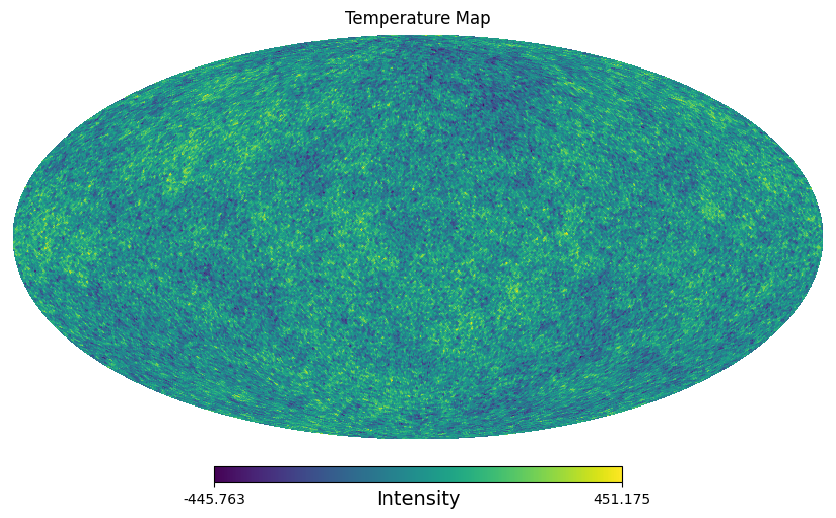

In [3]:
#Read the data
path_lcdm = "./simulated_maps/lcdm/"
map_temp_data = read_map(path_lcdm + 'cmb_map_0.fits')

#Visualize the map
nside = hp.npix2nside(len(map_temp_data))
#nside = 64
print(f"NSIDE: {nside}")

#Plot
hp.mollview(map_temp_data, title="Temperature Map", unit="Intensity")
plt.show()

In [4]:
layers = [hp_layer.HealpyChebyshev(K=10, Fout=5, use_bias=True, use_bn=True, 
                                   activation="relu"),
          hp_layer.HealpyPool(p=1),
          hp_layer.HealpyChebyshev(K=10, Fout=5, use_bias=True, use_bn=True, 
                                   activation="relu"),
          hp_layer.HealpyPool(p=1),
          hp_layer.HealpyChebyshev(K=10, Fout=5, use_bias=True, use_bn=True, 
                                   activation="relu"),
          hp_layer.HealpyPool(p=1),
          hp_layer.HealpyChebyshev(K=10, Fout=1),
          tf.keras.layers.Lambda(lambda x: tf.math.sigmoid(tf.reduce_mean(x, axis=1)))]

In [5]:
indices = np.arange(hp.nside2npix(nside))

In [6]:
model = HealpyGCNN(nside=nside, indices=indices, layers=layers, n_neighbors=20)
batch_size = 16
model.build(input_shape=(None, len(indices), 1))
model.summary(110)

25-05-23 15:38:11  sbi_flows INF   WARNING: This network assumes that everything concerning healpy is in NEST ordering... 
25-05-23 15:38:11  sbi_flows INF   Detected a reduction factor of 8.0, the input with nside 128 will be transformed to 16 during a forward pass. Checking for consistency with indices... 
25-05-23 15:38:11  sbi_flows INF   indices seem consistent... 


Model: "healpy_gcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ chebyshev (Chebyshev)                          │ (None, 196608, 5)                   │                  65 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ healpy_pool (HealpyPool)                       │ (None, 49152, 5)                    │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ chebyshev_1 (Chebyshev)                        │ (None, 49152, 5)                    │                 265 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ healpy_pool_1 (HealpyPool)                     │ (None, 12288, 5)                    │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ chebyshev_2 (Chebyshev)                        │ (None, 12288, 5)                    │                 265 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ healpy_pool_2 (HealpyPool)                     │ (None, 3072, 5)                     │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ chebyshev_3 (Chebyshev)                        │ (None, 3072, 1)                     │                  50 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ lambda (Lambda)                                │ (None, 1)                           │                   0 │
└────────────────────────────────────────────────┴─────────────────────────────────────┴─────────────────────┘

 Total params: 645 (2.52 KB)

 Trainable params: 615 (2.40 KB)

 Non-trainable params: 30 (120.00 B)

In [7]:
def read_all_maps(path_lcdm, path_feature, n_maps=100):
    maps = []
    labels = []
    
    #LCDM maps
    for i in range(n_maps):
        map_lcdm = read_map(f"{path_lcdm}cmb_map_{i}.fits")
        maps.append(map_lcdm)
        labels.append(0)  #lcdm
    
    #Feature maps
    for i in range(n_maps):
        map_feature = read_map(f"{path_feature}cmb_map_feature_{i}.fits")
        maps.append(map_feature)
        labels.append(1)  #feature
    
    maps = np.array(maps).astype(np.float32)[..., None]  #Add channel dimension
    labels = np.array(labels).astype(np.int32)
    #print(labels)
    return maps, labels

In [8]:
path_feature = "./simulated_maps/feature/"
x_raw, y_raw = read_all_maps(path_lcdm, path_feature, n_maps=100) #0: lcdm, 1:feature

Filename: ./simulated_maps/lcdm/cmb_map_0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   192R x 1C   [1024D]   
ColDefs(
    name = 'T'; format = '1024D'
)
Filename: ./simulated_maps/lcdm/cmb_map_1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   192R x 1C   [1024D]   
ColDefs(
    name = 'T'; format = '1024D'
)
Filename: ./simulated_maps/lcdm/cmb_map_2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   192R x 1C   [1024D]   
ColDefs(
    name = 'T'; format = '1024D'
)
Filename: ./simulated_maps/lcdm/cmb_map_3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU 

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_raw, y_raw, test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

#Memory efficifient data loading
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=100).batch(16).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(16)

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.1),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.BinaryAccuracy()],
)

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset,
    epochs=500)

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - binary_accuracy: 0.4798 - loss: 0.9502 - val_binary_accuracy: 0.6071 - val_loss: 6.9418
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - binary_accuracy: 0.5440 - loss: 0.6964 - val_binary_accuracy: 0.6071 - val_loss: 1.8203
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - binary_accuracy: 0.5479 - loss: 0.6913 - val_binary_accuracy: 0.6071 - val_loss: 0.7416
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - binary_accuracy: 0.4626 - loss: 0.6968 - val_binary_accuracy: 0.6071 - val_loss: 0.6668
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - binary_accuracy: 0.5063 - loss: 0.6956 - val_binary_accuracy: 0.6429 - val_loss: 0.6888
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - binary_accuracy: 0.5061 - loss: 0.6925 - val_binary_accuracy: 0.3571 - val_loss: 0.6964
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - binary_accuracy: 0.4757 - loss: 0.6987 - val_binary_accuracy: 0.7500 - val_loss: 0.6847
Epoch 8/500
7/7 ━━━━━━━━━━━

In [ ]:
#Function for the probability of classification as LCDM 
def normFeat(p):
  if 0<p<0.5:
    rr=1-p
  else:
    rr=p
  return rr

#Function for the probability of classification as Feature 
def normLCDM(p):
  if 0<p<0.5:
    rr=p
  else:
    rr=1-p
  return rr

In [ ]:
theory = ['LCDM','FT']

true_model=[]
pred_model=[]
prob_pred_MoG=[]
prob_pred_LCDM=[]
for i in range(len(x_test)):
  X_test_tf = tf.convert_to_tensor([x_test[i]])
  predictions = model.predict(X_test_tf)
  true_model.append(round(y_test[i]))
  pred_model.append(round(predictions[0][0]))
  prob_pred_MoG.append(round(100*normFeat(predictions[0][0]),3))
  prob_pred_LCDM.append(round(100*normLCDM(predictions[0][0]),3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Text(0, 0.5, 'Loss')

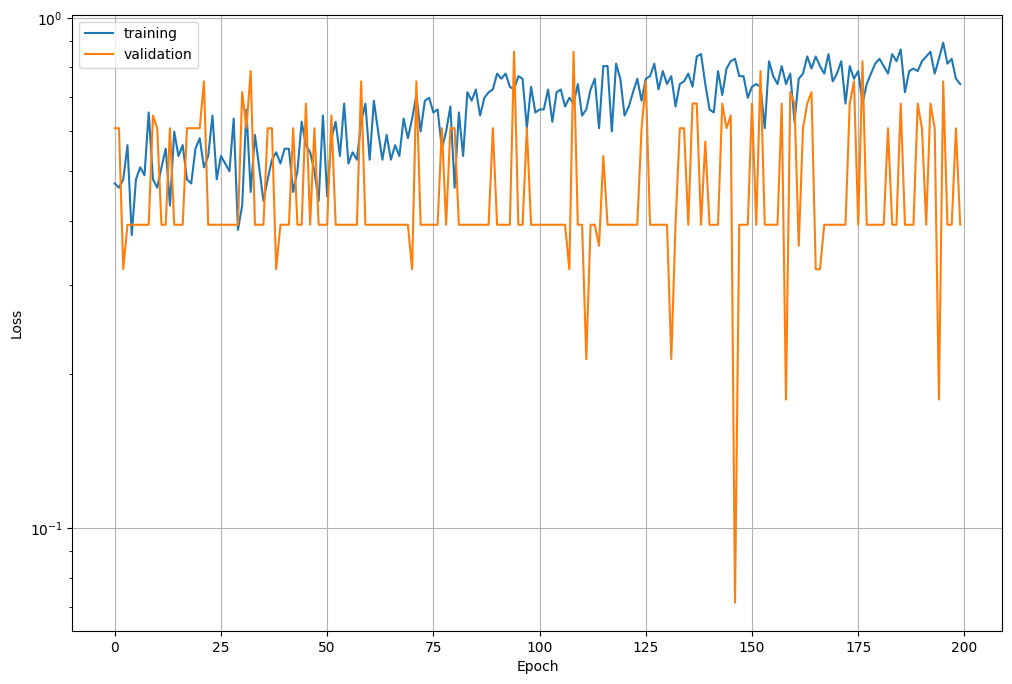

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history["binary_accuracy"], label="training")
plt.plot(history.history["val_binary_accuracy"], label="validation")
plt.grid()
plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

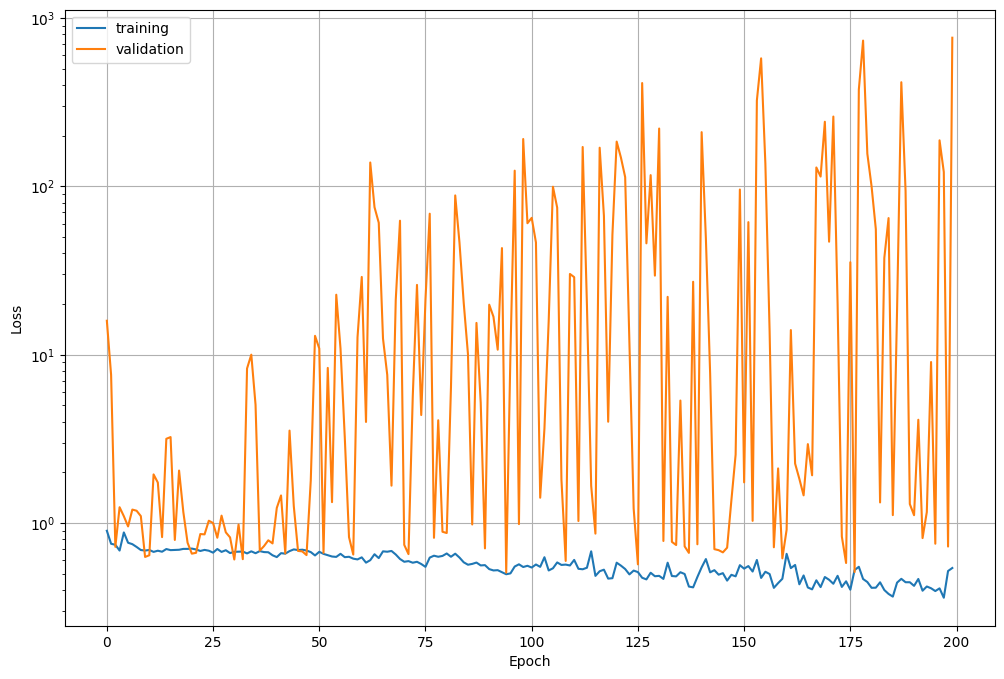

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history["loss"], label="training")
plt.plot(history.history["val_loss"], label="validation")
plt.grid()
plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [ ]:
#-----------------------------------------------------------------------------------------------------------
#Performance: correct & incorrect  predictions
#-----------------------------------------------------------------------------------------------------------
true_LCDM = []
true_MoG = []
false_LCDM = []
false_MoG = []

for pred, true in zip(pred_model, true_model):
    if pred==0 and true==0:
        true_LCDM.append(1)
    if pred==1 and true==1:
        true_MoG.append(1)
    if pred==0 and true==1:
        false_LCDM.append(1)
    if pred==1 and true==0:
        false_MoG.append(1)
lenghts=[len(true_LCDM),len(true_MoG),len(false_LCDM),len(false_MoG)]

print('     ','LCDM','MoG')
print('True ',len(true_LCDM)/sum(lenghts),len(true_MoG)/sum(lenghts))
print('False',len(false_LCDM)/sum(lenghts),len(false_MoG)/sum(lenghts))
print('--------------')
print("Correct prediction: ",(len(true_LCDM)+len(true_MoG))/sum(lenghts))
print("Wrong prediction  : ",(len(false_LCDM)+len(false_MoG))/sum(lenghts))

      LCDM MoG
True  0.5166666666666667 0.0
False 0.48333333333333334 0.0
--------------
Correct prediction:  0.5166666666666667
Wrong prediction  :  0.48333333333333334
